# Penyisihan Hology 8.0 2025 – Crowd Counting

Notebook ini mendokumentasikan proses end–to–end pengembangan model **Crowd Counting** untuk kompetisi *Penyisihan Hology 8.0 2025 Data Mining*. Fokus: membangun pipeline yang **reproducible**, **terstruktur**, dan **transparan** dari eksplorasi data, pembuatan density map, training model **CSRNet**, evaluasi, hingga pembuatan submission Kaggle.

**Tim:** Kibahino  
**Anggota:** Rhendy Japelhendal S. S., Gaung Taqwa Indraswara, Muhammad Irza Dzulhika  
**Institusi:** Universitas Brawijaya  
**Tanggal Revisi Terakhir:** 25 September 2025  

> Catatan: Semua eksperimen dikunci seed agar memudahkan verifikasi panitia (reproducibility).

## 1. Tujuan

Membangun model AI yang mampu menghitung jumlah orang pada citra kerumunan secara **akurat**, **robust di berbagai kepadatan**, dan **efisien untuk inferensi**. Hasil model dioptimalkan terhadap metrik kompetisi (**Mean Absolute Error / MAE**) dan dipastikan dapat direproduksi ulang (sesuai pedoman kompetisi).

Tujuan teknis yang diturunkan:

- Mendesain **arsitektur CSRNet** (VGG16 frontend + dilated convolution backend) untuk regresi density map.
- Mengonversi anotasi titik kepala menjadi **density map adaptif** (Gaussian dengan sigma berbasis k–nearest neighbors).
- Mengelola pipeline preprocessing sehingga dapat dilakukan **sekali**, lalu dipakai ulang (hemat waktu training).
- Menggunakan strategi **training stabil**: reproducible seed, adaptive LR scheduler, gradient clipping.
- Menyediakan alat evaluasi: agregasi **MAE global**, analisis per rentang kepadatan, dan **visualisasi prediksi**.
- Membuat **submission CSV** dengan format valid Kaggle dan menjaga dokumentasi langkah secara jelas.

##  2. Overview Kompetisi

Abi (petugas perencanaan kota) membutuhkan sistem untuk memantau potensi **overcrowding** menjelang Festival Harmoni Nusantara. Model crowd counting akan membantu identifikasi dini area padat, perencanaan jalur evakuasi, dan meningkatkan keselamatan pengunjung.

Dataset terdiri dari gambar kerumunan dengan variasi:
- Perspektif kamera & skala multi-level
- Kepadatan sangat rendah hingga sangat tinggi
- Variasi pencahayaan & oklusi

Model harus memperkirakan jumlah orang per gambar pada test set berdasarkan pembelajaran dari training set.


### Relevansi Aplikasi
- Manajemen kerumunan (acara, stadion, transportasi)
- Keamanan dan mitigasi risiko
- Analisis sosial & perencanaan fasilitas

### Sasaran Substantif
Bangun sistem yang bisa:  
1. Menghasilkan density map representatif  
2. Mengestimasi total crowd (sum density)  
3. Stabil di berbagai distribusi kepadatan  
4. Mudah dievaluasi & di-deploy sederhana

> Output utama untuk kompetisi: file `.csv` berisi `image_id` dan `predicted_count`.

## 3. Metrik Evaluasi

Kompetisi menggunakan **Mean Absolute Error (MAE)**:

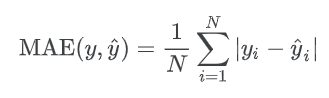

Keterangan:
- N = jumlah sampel test / validasi
- yᵢ = jumlah orang sebenarnya (ground truth)
- ŷᵢ = jumlah orang hasil prediksi

Semakin kecil nilai MAE → semakin baik. Fokus optimisasi diarahkan pada penurunan MAE secara konsisten tanpa overfitting ekstrem.

### Interpretasi Tambahan
- MAE toleran terhadap outlier ringan namun tetap mencerminkan kesalahan absolut praktis.
- Cocok untuk use case crowd counting karena stakeholders peduli selisih rata-rata aktual vs prediksi, bukan rasio.
- Alternatif (tidak digunakan di kompetisi): MSE, MAPE, SMAPE, GAME (Grid Average Mean absolute Error).

## 4. Dataset

Dataset berisi kumpulan citra crowd dengan anotasi titik kepala pada set pelatihan. Set test hanya menyediakan gambar tanpa label. Density map digunakan sebagai representasi kontinu kepadatan manusia.

### Struktur Direktori (Generik Kaggle)
```
train/
  images/   -> citra training
  labels/   -> file JSON anotasi kepala
preprocessed_maps/ (dibuat sendiri) -> density map .npy hasil konversi
test/
  images/   -> citra untuk inferensi
sample_submission.csv
```

### Format Label JSON
```json
{
  "img_id": "1.jpg",
  "human_num": 25,
  "points": [ [120,45], [340,78], [567,123] ]
}
```

### Format Submission
CSV dengan header: `image_id,predicted_count`
Contoh:
```
test_0001.jpg,17
test_0002.jpg,0
test_0003.jpg,42
```

> Count dihitung sebagai penjumlahan nilai density map prediksi dibulatkan ke bilangan bulat wajar (≥ 0).


##  5. Problem Understanding

Task: Regresi jumlah manusia pada sebuah citra dengan pendekatan **density estimation**. Bukan deteksi bounding box, melainkan memetakan kepadatan spasial sehingga robust terhadap occlusion dan crowd padat.


### Karakteristik Masalah
- Head size variatif karena perspektif / depth.
- Occlusion (kepala tertutup sebagian) umum terjadi.
- Distribusi jumlah orang sangat skewed (banyak gambar low–mid density, sebagian kecil high density).

### Tantangan Utama
1. **Scaling & Perspektif** – objek semakin kecil di bagian jauh gambar.
2. **High Density Clutter** – jarak antar kepala sangat rapat → risiko undercount.
3. **Lighting & Noise** – perubahan pencahayaan mengganggu generalisasi.
4. **Kernel Sensitivity** – sigma Gaussian terlalu besar → over-smoothing; terlalu kecil → noisy.
5. **Distribusi Tidak Seimbang** – model cenderung bias ke rentang density dominan.

### Strategi Mitigasi
| Tantangan | Strategi |
|-----------|----------|
| Perspektif | Dilated backend (CSRNet) + adaptive kernel |
| High density | Weighted loss untuk high count |
| Lighting | Normalisasi ImageNet + (opsional) augmentasi |
| Kernel tuning | Sigma adaptif via KNN distance |
| Imbalance | Analisis per rentang (& bisa ditambah focal weighting) |

## 6. Pendekatan / Solusi Teknis

Gunakan paradigma **density regression** dengan arsitektur **CSRNet** (VGG16 pretrained → feature extraction + dilated convolution stack → 1-channel density map). Loss dikombinasi dan diberi penyesuaian bobot berdasarkan total count target.

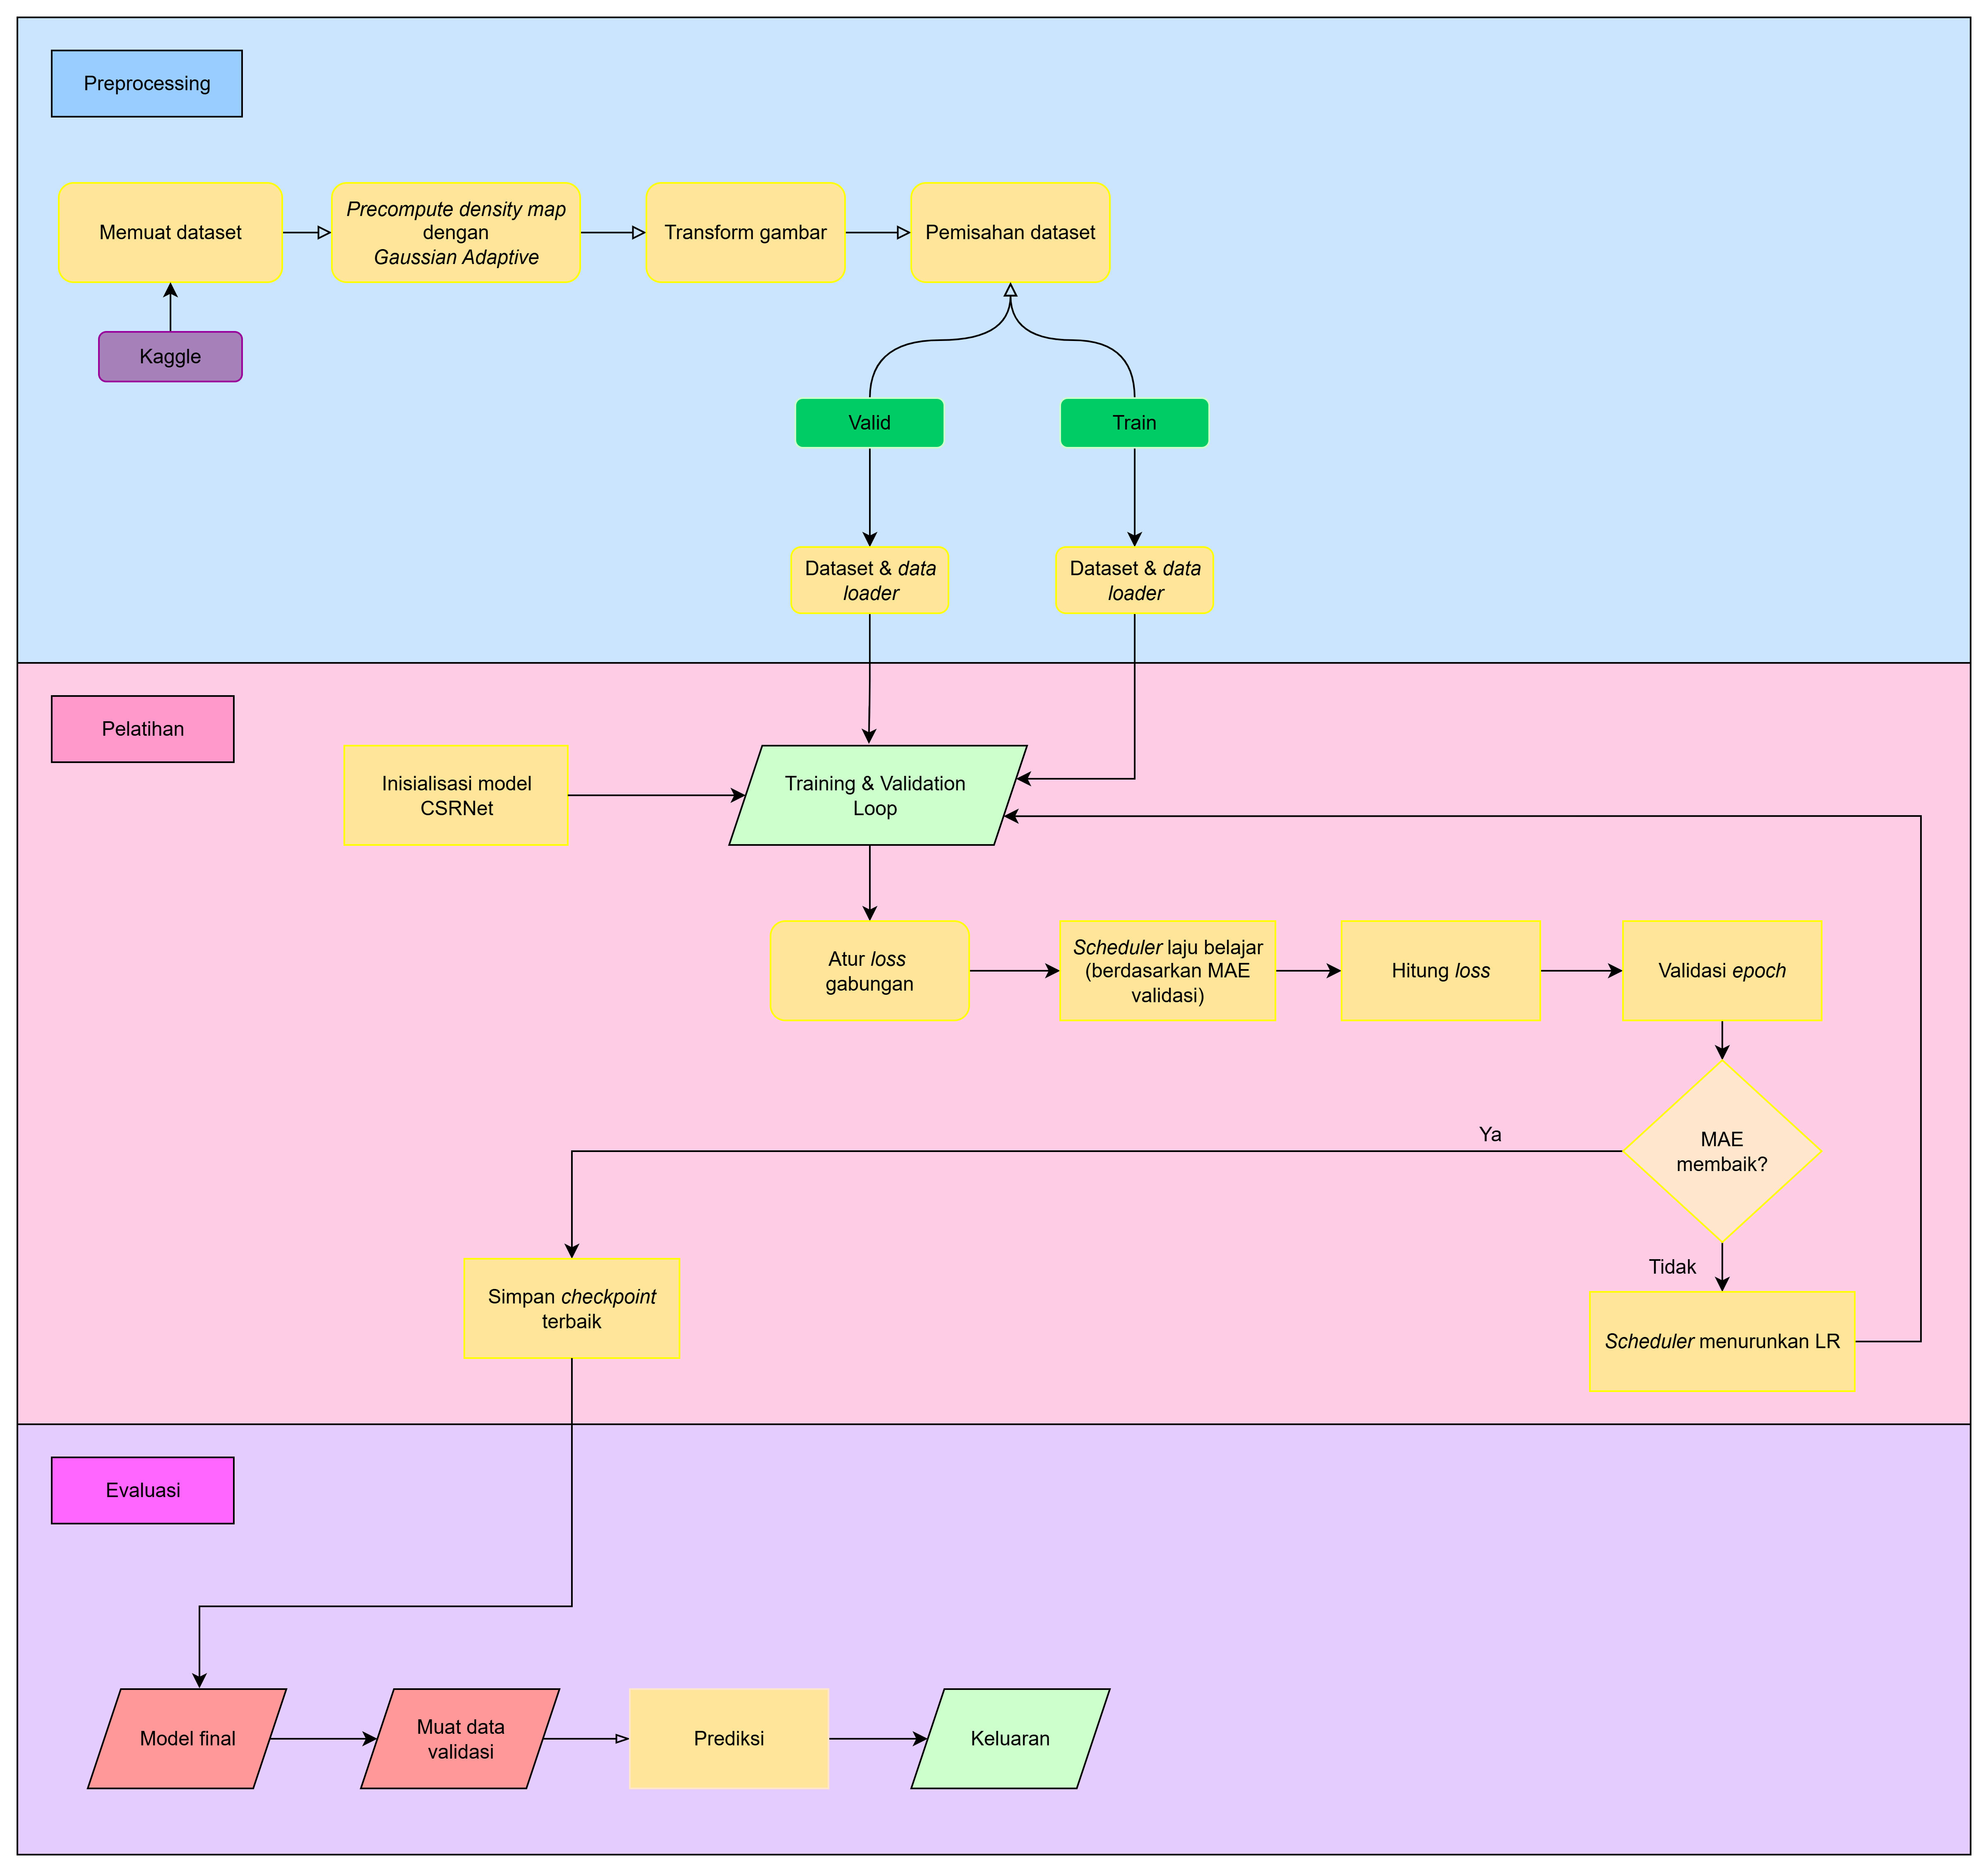

### Komponen Solusi
- **Model**: CSRNet (stabil & banyak dipakai untuk crowd counting).
- **Label**: Density map adaptif (sigma proporsional ke rata-rata jarak tetangga terdekat).
- **Loss**: MSE (pixel-wise) + MAE (global count) dengan penyesuaian bobot density tinggi.
- **Optimisasi**: Adam + ReduceLROnPlateau (berbasis MAE validasi) + gradient clipping.
- **Monitoring**: Simpan best checkpoint berdasarkan MAE; logging status (STABLE/VOLATILE).
- **Evaluasi**: MAE total + breakdown per rentang density + visualisasi GT vs Pred density.

> Rationale: Kombinasi MSE + MAE menjaga kualitas lokal (struktur density) dan akurasi agregat (total count).

## Langkah 1 — Setup & Konfigurasi
Menyiapkan impor library inti, fungsi utilitas, dan konfigurasi seed agar seluruh eksperimen dapat direplikasi (reproducible).

### 1.1. Import Library
Library dibagi berdasarkan peran: manajemen file, scientific computing, deep learning, visualisasi, hingga konstruksi density map adaptif.

Ringkasan fungsi tiap kelompok:
- File & Sistem: `os`, `json`, `shutil`
- Randomness & Numerik: `random`, `numpy`, `pandas`
- DL Core: `torch`, `torch.nn`, `torch.optim`, `torchvision`
- Data Pipeline: `Dataset`, `DataLoader`, `transforms`
- Preprocessing & Geometry: `KDTree`, `gaussian_filter`
- Evaluasi & Viz: `matplotlib`, `tqdm`

> Catatan: `joblib` dapat digunakan untuk paralelisasi preprocessing jika perlu scale-up.

In [ ]:
# ===================================================================
# Langkah 1: Setup, Impor Library, dan Konfigurasi Awal
# ===================================================================
import os
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

### 1.2. Reproducibility
Menetapkan SEED global agar hasil (loss curve, MAE, pemilihan split) konsisten ketika diverifikasi panitia. Mengaktifkan mode deterministik untuk operasi CUDA tertentu.

Praktik yang diterapkan:
- Set seed di Python, NumPy, dan PyTorch (CPU & GPU)
- Menonaktifkan algoritma nondeterministik cuDNN
- Memastikan hasil training dapat direplikasi tanpa variasi signifikan

> Perbedaan minor (floating point) masih mungkin terjadi antar GPU / driver, namun tidak material terhadap tren MAE.

In [ ]:
# Atur seed untuk reprodusibilitas sesuai aturan kompetisi
SEED = 2025
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
penyisihan_hology_8_0_2025_data_mining_path = kagglehub.competition_download('penyisihan-hology-8-0-2025-data-mining')

print('Data source import complete.')

Data source import complete.


## Langkah 2 — Metadata & DataFrame

Mempersiapkan struktur metadata agar akses gambar & label menjadi terstandar dan mempermudah audit.

### 2.1. Ringkasan Isi Dataset
| Kategori | Jumlah | Deskripsi |
|----------|--------|-----------|
| Train Images | 1,900 | Citra crowd beranotasi |
| Train Labels | 1,900 | JSON titik kepala |
| Test Images | 500 | Tanpa label (inferensi) |
| Submission Template | 1 | Contoh format CSV |

In [ ]:
# Tentukan path ke direktori data di Kaggle
BASE_PATH = penyisihan_hology_8_0_2025_data_mining_path
TRAIN_IMG_PATH = os.path.join(BASE_PATH, 'train/images')
TRAIN_LBL_PATH = os.path.join(BASE_PATH, 'train/labels')
TEST_IMG_PATH = os.path.join(BASE_PATH, 'test/images')

print(f"Path gambar training: {TRAIN_IMG_PATH}")
print(f"Path label training: {TRAIN_LBL_PATH}")
print(f"Path gambar testing: {TEST_IMG_PATH}")

Path gambar training: /kaggle/input/penyisihan-hology-8-0-2025-data-mining/train/images
Path label training: /kaggle/input/penyisihan-hology-8-0-2025-data-mining/train/labels
Path gambar testing: /kaggle/input/penyisihan-hology-8-0-2025-data-mining/test/images


### 2.2. Kolom DataFrame
| Kolom | Isi |
|-------|-----|
| id | ID unik gambar (tanpa ekstensi) |
| image_path | Path absolut/relatif file .jpg |
| label_path | Path file JSON anotasi |
| (dinamis) human_num | Total orang (dari JSON) |
| (dinamis) n_points | Panjang daftar koordinat |

> Kolom tambahan (human_num, n_points) dapat dihitung saat eksplorasi / validasi label.

In [ ]:
# ===================================================================
# Langkah 2: Memuat Metadata dan Membuat DataFrame
# ===================================================================
# Dapatkan daftar semua ID gambar dari nama file di direktori gambar
train_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(TRAIN_IMG_PATH) if f.endswith('.jpg')])

# Buat DataFrame untuk menyimpan path
train_metadata = []
for img_id in train_ids:
    img_path = os.path.join(TRAIN_IMG_PATH, f"{img_id}.jpg")
    lbl_path = os.path.join(TRAIN_LBL_PATH, f"{img_id}.json")
    train_metadata.append({'id': img_id, 'image_path': img_path, 'label_path': lbl_path})

df_train = pd.DataFrame(train_metadata)

print("Contoh 5 baris pertama metadata training:")
print(df_train.head())

Contoh 5 baris pertama metadata training:
     id                                         image_path  \
0     1  /kaggle/input/penyisihan-hology-8-0-2025-data-...   
1    10  /kaggle/input/penyisihan-hology-8-0-2025-data-...   
2   100  /kaggle/input/penyisihan-hology-8-0-2025-data-...   
3  1000  /kaggle/input/penyisihan-hology-8-0-2025-data-...   
4  1001  /kaggle/input/penyisihan-hology-8-0-2025-data-...   

                                          label_path  
0  /kaggle/input/penyisihan-hology-8-0-2025-data-...  
1  /kaggle/input/penyisihan-hology-8-0-2025-data-...  
2  /kaggle/input/penyisihan-hology-8-0-2025-data-...  
3  /kaggle/input/penyisihan-hology-8-0-2025-data-...  
4  /kaggle/input/penyisihan-hology-8-0-2025-data-...  


### 2.3. Tujuan Penyusunan Metadata
- Memudahkan cross-check konsistensi (jumlah file gambar vs label)
- Memastikan tidak ada file orphan / mismatch
- Menjadi dasar pembuatan dataset PyTorch


In [ ]:
import os, numpy as np

# Subfolder dalam dua part
folder1 = "/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-001/preprocessed_maps"
folder2 = "/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-002/preprocessed_maps"

# Gabungkan semua file .npy
files = []
for f in os.listdir(folder1):
    if f.endswith(".npy"):
        files.append(os.path.join(folder1, f))
for f in os.listdir(folder2):
    if f.endswith(".npy"):
        files.append(os.path.join(folder2, f))

print(len(files), "files ditemukan")
print(files[:5])

# Load salah satu npy
arr = np.load(files[0])
print("Shape:", arr.shape)

1900 files ditemukan
['/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-001/preprocessed_maps/422.npy', '/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-001/preprocessed_maps/331.npy', '/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-001/preprocessed_maps/280.npy', '/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-001/preprocessed_maps/970.npy', '/kaggle/input/hology/preprocessed_maps-20250925T091212Z-1-001/preprocessed_maps/745.npy']
Shape: (434, 650)


## (EDA) Exploratory Data Analysis – Distribusi & Kualitas Data

Bagian ini ditambahkan untuk:
- Memahami distribusi jumlah orang per gambar (skewness, heavy-tail, outlier)
- Mengecek konsistensi label JSON (`human_num` vs panjang `points`)
- Mengamati ukuran (dimensi) citra dan potensi kebutuhan resize adaptif
- Memvalidasi bucket kepadatan guna desain weighting loss / strategi sampling

Langkah inti yang akan dilakukan:
1. Parse seluruh file JSON label dan memperkaya `df_train` dengan kolom: `human_num`, `n_points`, `count_bucket`.
2. Statistik deskriptif (mean, median, std, min, max, quartiles) + skewness & kurtosis.
3. Visualisasi distribusi (histogram linear & log), CDF sederhana, dan bar chart bucket.
4. Pemeriksaan anomali: mismatch `human_num` vs `len(points)`, nilai negatif / duplikat koordinat.
5. Analisis ukuran gambar (sample) untuk potensi aspect ratio distortion.

> Catatan: Sel-sel EDA ini aman dijalankan sebelum proses lanjutan. Jika dataset tidak tersedia di lingkungan lokal (mis. bukan di Kaggle), kode akan otomatis melakukan graceful skip.

In [ ]:
# EDA 1: Memperkaya DataFrame dengan informasi label
import math, gc, statistics
from collections import Counter

if 'df_train' in globals():
    enriched_rows = []
    label_mismatch = 0
    json_missing = 0
    for _, row in df_train.iterrows():
        lbl_path = row['label_path']
        human_num = None
        n_points = None
        points = []
        if os.path.exists(lbl_path):
            try:
                with open(lbl_path, 'r') as f:
                    data = json.load(f)
                human_num = data.get('human_num', None)
                points = data.get('points', []) or []
                n_points = len(points)
                if human_num is not None and n_points is not None and human_num != n_points:
                    label_mismatch += 1
            except Exception as e:
                print(f"Gagal membaca {lbl_path}: {e}")
        else:
            json_missing += 1
        enriched_rows.append({
            'id': row['id'],
            'image_path': row['image_path'],
            'label_path': row['label_path'],
            'human_num': human_num,
            'n_points': n_points,
            'points': points
        })
    df_train_enriched = pd.DataFrame(enriched_rows)
    print("Ukuran df_train_enriched:", df_train_enriched.shape)
    print("Jumlah label mismatch (human_num != len(points)):", label_mismatch)
    print("Jumlah label JSON hilang:", json_missing)
else:
    print("df_train belum terdefinisi. Lewati EDA.")

Ukuran df_train_enriched: (1900, 6)
Jumlah label mismatch (human_num != len(points)): 0
Jumlah label JSON hilang: 0


In [ ]:
# EDA 2: Statistik Deskriptif & Distribusi Count
if 'df_train_enriched' in globals():
    # Gunakan n_points bila human_num null
    df_train_enriched['count'] = df_train_enriched.apply(
        lambda r: r['human_num'] if pd.notnull(r['human_num']) else r['n_points'], axis=1
    )
    valid_counts = df_train_enriched['count'].dropna().astype(float)
    if len(valid_counts) == 0:
        print("Tidak ada count valid untuk dianalisis.")
    else:
        desc = valid_counts.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])
        skewness = valid_counts.skew()
        kurtosis = valid_counts.kurtosis()
        print("Ringkasan Statistik Count:")
        print(desc)
        print(f"Skewness: {skewness:.3f} | Kurtosis: {kurtosis:.3f}")
        print("Top 5 nilai terbesar:", valid_counts.sort_values(ascending=False).head().tolist())
        print("Top 5 nilai terkecil:", valid_counts.sort_values(ascending=True).head().tolist())
else:
    print("df_train_enriched belum tersedia.")

Ringkasan Statistik Count:
count    1900.000000
mean      138.899474
std       285.247091
min         1.000000
25%        10.000000
50%        28.000000
75%       146.000000
90%       369.200000
95%       602.050000
99%      1535.110000
max      3139.000000
Name: count, dtype: float64
Skewness: 4.626 | Kurtosis: 28.690
Top 5 nilai terbesar: [3139.0, 2673.0, 2650.0, 2348.0, 2261.0]
Top 5 nilai terkecil: [1.0, 1.0, 2.0, 2.0, 2.0]


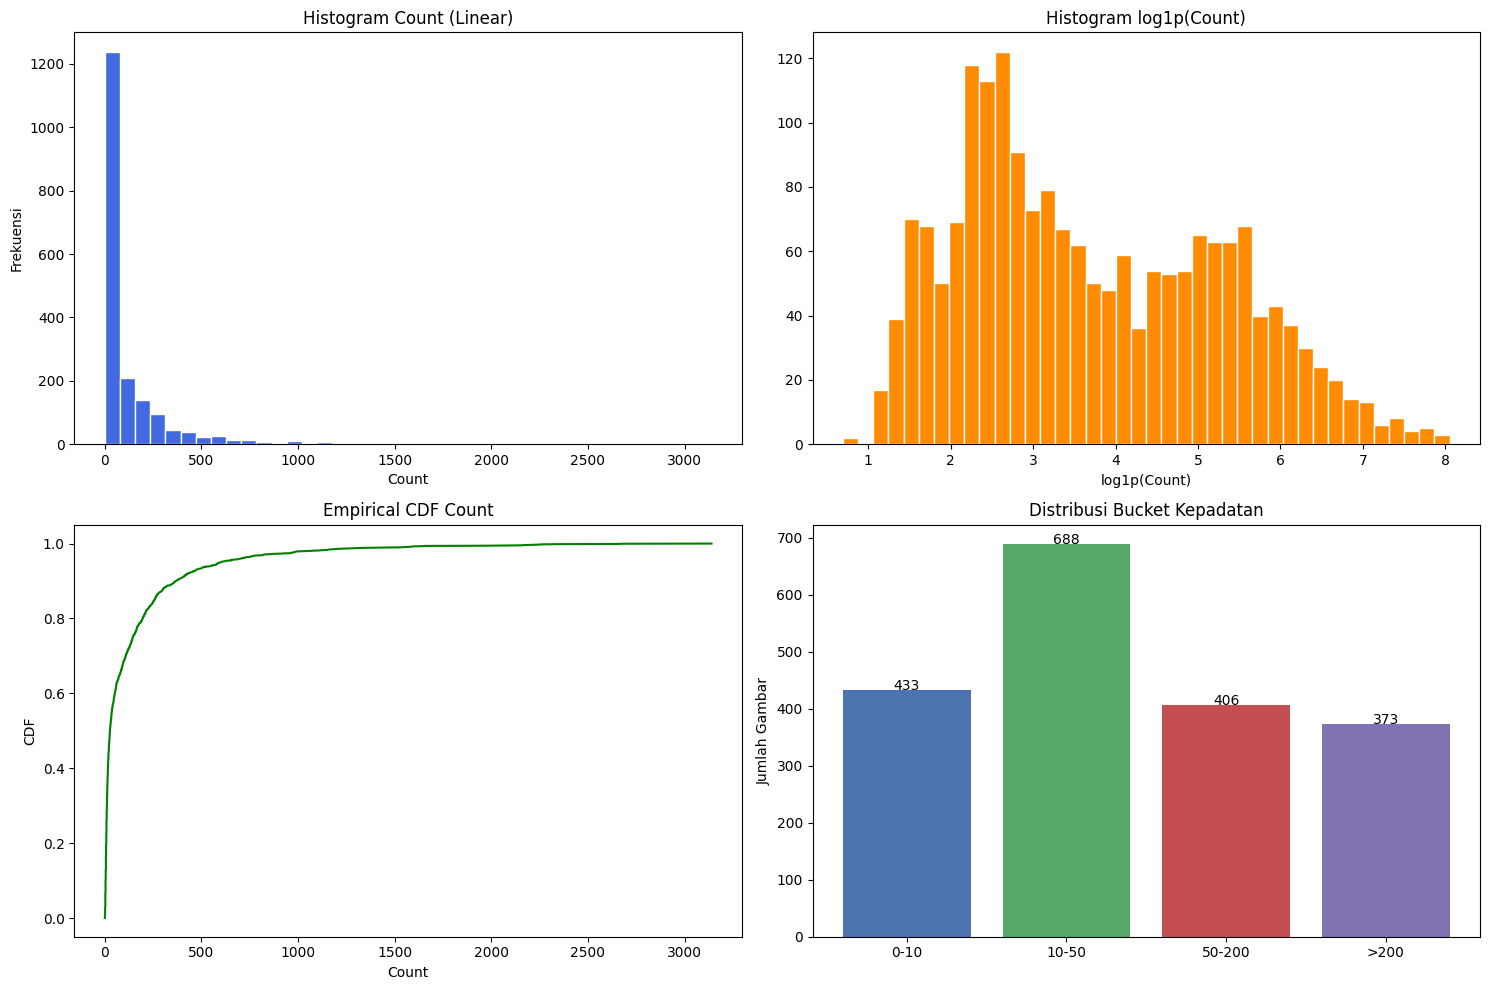

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'df_train_enriched' in globals() and 'count' in df_train_enriched.columns:
    counts = df_train_enriched['count'].dropna().astype(float)
    if len(counts) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid

        # Histogram linear
        axes[0, 0].hist(counts, bins=40, color='royalblue', edgecolor='white')
        axes[0, 0].set_title('Histogram Count (Linear)')
        axes[0, 0].set_xlabel('Count')
        axes[0, 0].set_ylabel('Frekuensi')

        # Histogram log
        axes[0, 1].hist(np.log1p(counts), bins=40, color='darkorange', edgecolor='white')
        axes[0, 1].set_title('Histogram log1p(Count)')
        axes[0, 1].set_xlabel('log1p(Count)')

        # CDF
        sorted_counts = np.sort(counts)
        cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
        axes[1, 0].plot(sorted_counts, cdf, color='green')
        axes[1, 0].set_title('Empirical CDF Count')
        axes[1, 0].set_xlabel('Count')
        axes[1, 0].set_ylabel('CDF')

        # Bucket frequency
        buckets = [(0, 10), (10, 50), (50, 200), (200, 1e9)]
        labels = ['0-10', '10-50', '50-200', '>200']
        bucket_freq = []
        for lo, hi in buckets:
            bucket_freq.append(((counts >= lo) & (counts < hi)).sum())
        axes[1, 1].bar(labels, bucket_freq, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])
        axes[1, 1].set_title('Distribusi Bucket Kepadatan')
        axes[1, 1].set_ylabel('Jumlah Gambar')

        # Annotate values on bar plot
        for i, v in enumerate(bucket_freq):
            axes[1, 1].text(i, v + 0.5, str(v), ha='center', fontsize=10)

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()
    else:
        print("Tidak ada count untuk divisualisasikan.")
else:
    print("Data belum siap untuk visualisasi.")

In [ ]:
# EDA 4: Pemeriksaan Anomali Label & Duplikasi Koordinat
from collections import defaultdict

if 'df_train_enriched' in globals():
    mismatch_rows = df_train_enriched[
        (df_train_enriched['human_num'].notnull()) &
        (df_train_enriched['n_points'].notnull()) &
        (df_train_enriched['human_num'] != df_train_enriched['n_points'])
    ]
    print(f"Total mismatch human_num vs n_points: {len(mismatch_rows)}")

    duplicate_counts = []
    sample_dupe_examples = []
    for _, r in df_train_enriched.iterrows():
        pts = r['points'] if isinstance(r['points'], list) else []
        if pts:
            c = Counter(tuple(p) for p in pts)
            dupes = [p for p,v in c.items() if v>1]
            if dupes:
                duplicate_counts.append(len(dupes))
                sample_dupe_examples.append({'id': r['id'], 'duplicates': dupes[:5]})
    if duplicate_counts:
        print(f"Gambar dengan duplikasi koordinat: {len(duplicate_counts)}")
        print("Contoh:", sample_dupe_examples[:3])
    else:
        print("Tidak ditemukan duplikasi koordinat signifikan.")
else:
    print("df_train_enriched tidak tersedia untuk pemeriksaan anomali.")

Total mismatch human_num vs n_points: 0
Gambar dengan duplikasi koordinat: 1898
Contoh: [{'id': '1', 'duplicates': [('x', 'y')]}, {'id': '10', 'duplicates': [('x', 'y')]}, {'id': '100', 'duplicates': [('x', 'y')]}]


Statistik mean jarak tetangga (subset, n= 50 ) :
count     50.000000
mean      63.124312
std       44.223737
min       11.597913
25%       29.040305
50%       54.058153
75%       83.307116
max      203.990235
dtype: float64


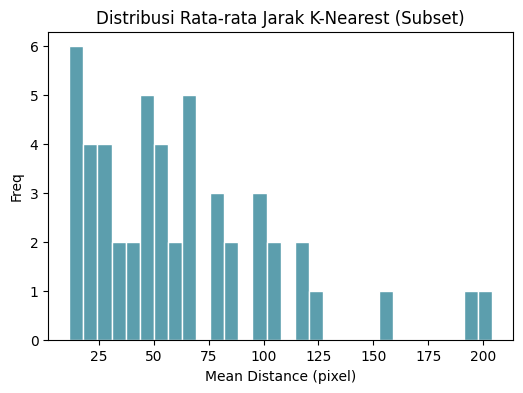

In [ ]:
# EDA 5: Distribusi Jarak Antar Titik (Sampling) untuk Mendukung Adaptive Sigma (Revisi Robust)
import random
from scipy.spatial import KDTree

# Helper untuk mengekstrak koordinat konsisten (list of [x,y])
def normalize_points(raw_points):
    normalized = []
    if not isinstance(raw_points, (list, tuple)):
        return normalized
    for p in raw_points:
        # Bentuk sudah [x, y]
        if isinstance(p, (list, tuple)) and len(p) == 2:
            try:
                x = float(p[0]); y = float(p[1])
                normalized.append([x, y])
            except Exception:
                continue
        # Bentuk dict {"x":..., "y":...} atau {"X":..., "Y":...}
        elif isinstance(p, dict):
            # Coba berbagai key umum
            for kx, ky in [("x","y"),("X","Y"),("lon","lat"),("col","row")]:
                if kx in p and ky in p:
                    try:
                        x = float(p[kx]); y = float(p[ky])
                        normalized.append([x, y])
                        break
                    except Exception:
                        continue
        # Abaikan format lain
    return normalized

if 'df_train_enriched' in globals():
    sampled_df = df_train_enriched.dropna(subset=['n_points'])
    sampled_df = sampled_df[sampled_df['n_points'] > 5]
    if len(sampled_df) == 0:
        print("Tidak ada sampel dengan >5 titik untuk analisis jarak.")
    else:
        sampled_df = sampled_df.sample(min(50, len(sampled_df)), random_state=SEED)
        all_mean_dists = []
        invalid_samples = 0
        for _, r in sampled_df.iterrows():
            pts = normalize_points(r['points'])
            if len(pts) < 5:
                invalid_samples += 1
                continue
            try:
                tree = KDTree(pts)
                dists, _ = tree.query(pts, k=4)  # k termasuk diri sendiri
                # Gunakan mean neighbor (exclude self-dist 0) rata-rata
                local_mean = float(np.mean(dists[:, 1:]))
                if math.isfinite(local_mean):
                    all_mean_dists.append(local_mean)
            except Exception as e:
                invalid_samples += 1
                continue
        if all_mean_dists:
            all_mean_dists = np.array(all_mean_dists)
            print("Statistik mean jarak tetangga (subset, n=", len(all_mean_dists), ") :")
            print(pd.Series(all_mean_dists).describe())
            plt.figure(figsize=(6,4))
            plt.hist(all_mean_dists, bins=30, color='#5C9EAD', edgecolor='white')
            plt.title('Distribusi Rata-rata Jarak K-Nearest (Subset)')
            plt.xlabel('Mean Distance (pixel)'); plt.ylabel('Freq')
            plt.show()
            if invalid_samples:
                print(f"Sample dilewati karena format/insufisien: {invalid_samples}")
        else:
            print("Tidak cukup data valid untuk analisis jarak.")
else:
    print("df_train_enriched belum ada.")

## (Statistik) Analisis Inferensial Tambahan

Untuk mendukung justifikasi metode adaptif dan weighting:
- Uji normalitas pada distribusi count (Shapiro–Wilk pada subset) → biasanya non-normal (skewed) → justifikasi penggunaan metrik robust.
- Korelasi antara log(count) dan rata-rata jarak KNN (hipotesis: semakin padat → jarak rata-rata lebih kecil).
- Jika korelasi negatif kuat → mendukung desain sigma proporsional terhadap jarak tetangga.

Langkah:
1. Ambil subset `counts` (maks 500 agar uji Shapiro stabil).
2. Hitung Shapiro–Wilk p-value.
3. Estimasikan korelasi Spearman antara log(count) dan mean distance subset (dari EDA 5) jika tersedia.


In [ ]:
# Statistik 1: Uji Normalitas & Korelasi Spearman
from scipy.stats import shapiro, spearmanr

if 'df_train_enriched' in globals():
    counts_series = df_train_enriched['count'].dropna().astype(float) if 'count' in df_train_enriched.columns else None
    if counts_series is not None and len(counts_series) > 10:
        subset_counts = counts_series.sample(min(500, len(counts_series)), random_state=SEED)
        stat, pval = shapiro(subset_counts)
        print(f"Shapiro-Wilk: statistic={stat:.4f}, p-value={pval:.4g}")
        if pval < 0.05:
            print("Distribusi count berbeda signifikan dari normal (skewed/heavy-tailed).")
        else:
            print("Tidak cukup bukti menolak normalitas pada subset.")
    else:
        print("Data count tidak cukup untuk uji normalitas.")

    # Korelasi log(count) vs mean distance (jika all_mean_dists tersedia)
    if 'all_mean_dists' in globals() and isinstance(all_mean_dists, np.ndarray) and len(all_mean_dists)>5:
        # Samakan panjang dengan membuat subset count
        usable = min(len(all_mean_dists), len(counts_series))
        corr_stat, corr_p = spearmanr(np.log1p(counts_series.sample(usable, random_state=SEED)), all_mean_dists[:usable])
        print(f"Spearman Correlation log(count) vs mean_distance: rho={corr_stat:.3f}, p-value={corr_p:.4g}")
        if corr_stat < -0.3 and corr_p < 0.05:
            print("Korelasi negatif moderat/kuat → mendukung adaptive sigma (padat => jarak kecil).")
    else:
        print("Belum ada data jarak (all_mean_dists) untuk korelasi.")
else:
    print("df_train_enriched belum tersedia.")

Shapiro-Wilk: statistic=0.4999, p-value=3.514e-35
Distribusi count berbeda signifikan dari normal (skewed/heavy-tailed).
Spearman Correlation log(count) vs mean_distance: rho=0.023, p-value=0.8753


## (Insight) Ringkasan Otomatis & Rekomendasi
Sel ini akan mencoba merangkum temuan EDA secara programatik dan memberi rekomendasi langkah eksperimen lanjutan (jika data tersedia).

In [ ]:
# Insight 1: Generasi Ringkasan Otomatis
if 'df_train_enriched' in globals() and 'count' in df_train_enriched.columns:
    counts = df_train_enriched['count'].dropna().astype(float)
    if len(counts)>0:
        summary = counts.describe()
        skewness = counts.skew(); kurtosis = counts.kurtosis()
        buckets = {'0-10': ((counts>=0)&(counts<10)).sum(),
                   '10-50': ((counts>=10)&(counts<50)).sum(),
                   '50-200': ((counts>=50)&(counts<200)).sum(),
                   '>200': (counts>=200).sum()}
        dominant_bucket = max(buckets, key=buckets.get)
        print("=== RINGKASAN DATA CROWD COUNTING ===")
        print(summary)
        print(f"Skewness: {skewness:.2f} (skewed kanan) | Kurtosis: {kurtosis:.2f}")
        print("Distribusi Bucket:")
        for k,v in buckets.items():
            print(f"  {k}: {v} ({v/len(counts)*100:.1f}% )")
        print(f"Bucket dominan: {dominant_bucket}")

=== RINGKASAN DATA CROWD COUNTING ===
count    1900.000000
mean      138.899474
std       285.247091
min         1.000000
25%        10.000000
50%        28.000000
75%       146.000000
max      3139.000000
Name: count, dtype: float64
Skewness: 4.63 (skewed kanan) | Kurtosis: 28.69
Distribusi Bucket:
  0-10: 433 (22.8% )
  10-50: 688 (36.2% )
  50-200: 406 (21.4% )
  >200: 373 (19.6% )
Bucket dominan: 10-50


## Langkah 3 — Preprocessing & Density Map

### 3.1. Alasan Precompute Density Map
| Alasan | Manfaat |
|--------|---------|
| Menghindari komputasi ulang Gaussian | Percepat training multi-epoch |
| Pisahkan artefak turunan | Data mentah tetap bersih |
| Konsistensi antar eksperimen | Reproducibility tinggi |

In [ ]:
import shutil

PREPROCESSED_MAP_PATH = '/kaggle/working/preprocessed_maps/'
os.makedirs(PREPROCESSED_MAP_PATH, exist_ok=True)

for f in files:  # files hasil list dari folder1 dan folder2
    shutil.copy(f, PREPROCESSED_MAP_PATH)

# Cek hasil copy
copied_files = os.listdir(PREPROCESSED_MAP_PATH)
print(len(copied_files), "files disalin ke working")
print(copied_files[:5])


1900 files disalin ke working
['138.npy', '751.npy', '244.npy', '19.npy', '425.npy']


### 3.2. Transformasi Gambar
1. Resize → (768 × 1024) menjaga kompromi antara detail & memori.
2. ToTensor → Normalisasi rentang [0,1].
3. Normalize → Align dengan distribusi ImageNet (transfer learning).

In [ ]:
# Definisikan Transformasi Gambar
TARGET_H, TARGET_W = 768, 1024
image_transforms = transforms.Compose([
    transforms.Resize((TARGET_H, TARGET_W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 3.3. Density Map Adaptif (KNN-Based)
- Setiap titik kepala di-*spread* menggunakan Gaussian.
- Sigma diturunkan dari rata-rata jarak k tetangga terdekat.
- Crowd padat → sigma kecil (presisi lokal)
- Crowd jarang → sigma besar (distribusi menyebar)

In [ ]:
# ===================================================================
# Langkah 3: Fungsi Utilitas untuk Membuat Peta Kepadatan
# ===================================================================
def create_adaptive_density_map(image_shape, points, k=4, beta=0.3):
    """Membuat ground truth density map dengan kernel Gaussian adaptif."""
    height, width = image_shape
    density_map = np.zeros((height, width), dtype=np.float32)
    num_points = len(points)

    if num_points == 0:
        return density_map

    if num_points < k:
        for x, y in points:
            x, y = int(x), int(y)
            if 0 <= x < width and 0 <= y < height:
                density_map[y, x] = 1
        density_map = gaussian_filter(density_map, sigma=15)
        return density_map

    kdtree = KDTree(points)
    distances, _ = kdtree.query(points, k=k)

    for i, (x, y) in enumerate(points):
        avg_distance = np.mean(distances[i][1:]) if k > 1 else distances[i]
        if avg_distance < 1e-6:
            avg_distance = np.mean(distances[distances > 1e-6]) if np.any(distances > 1e-6) else 15
        sigma = avg_distance * beta

        x, y = int(x), int(y)
        if 0 <= x < width and 0 <= y < height:
            point_map = np.zeros((height, width), dtype=np.float32)
            point_map[y, x] = 1
            density_map += gaussian_filter(point_map, sigma=sigma)

    return density_map

### 3.4. Validasi Internal
- Sum(density_map) ≈ jumlah titik
- Dipakai sebagai ground truth regresi spatio–density

> Catatan: Untuk kasus tanpa titik (kosong) → density map nol (aman untuk loss).

## (Visualisasi) Head Points & Density Map
Visualisasi ini membantu:
- Memverifikasi bahwa koordinat anotasi selaras dengan konten gambar
- Menilai sebaran spasial crowd (cluster / sparse)
- Memastikan density map adaptif men-sum mendekati jumlah titik (konservasi count)

Panel yang akan ditampilkan untuk 1 sampel:
1. Gambar asli + overlay titik kepala
2. Density map ground truth (cmap=jet) + sum

Panel tambahan (opsional batch/grid) untuk beberapa sampel sekaligus guna inspeksi cepat.

> Jalankan setelah `df_train_enriched` tersedia dan peta density precomputed sudah tersalin ke folder kerja.

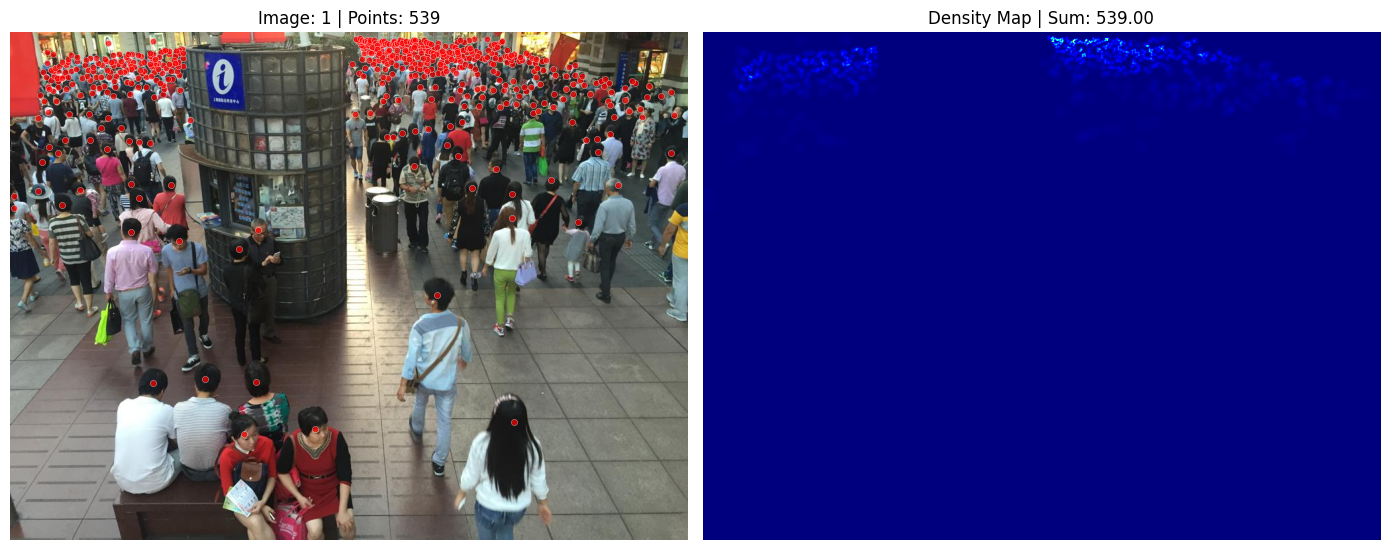

Perbedaan count (|points - sum|): 0.0


In [ ]:
# Visualisasi 1: Fungsi untuk menampilkan 1 sampel (gambar + titik + density map)
from matplotlib import patches

def visualize_single_sample(sample_id: str,
                             df_meta=None,
                             maps_dir='/kaggle/working/preprocessed_maps/',
                             point_color='red',
                             point_size=20):
    """
    Menampilkan:
    - Gambar asli dengan overlay titik kepala
    - Density map ground truth + sum(density)
    Args:
        sample_id: ID gambar tanpa ekstensi
        df_meta: DataFrame berisi kolom ['id','image_path','points'] (gunakan df_train_enriched)
        maps_dir: folder tempat density map .npy berada
    """
    if df_meta is None or 'id' not in df_meta.columns:
        print("DataFrame metadata tidak tersedia atau kolom 'id' hilang.")
        return
    row = df_meta[df_meta['id'] == sample_id]
    if row.empty:
        print(f"Sample {sample_id} tidak ditemukan.")
        return
    row = row.iloc[0]
    img_path = row['image_path']
    map_path = os.path.join(maps_dir, f"{sample_id}.npy")
    if not os.path.exists(img_path):
        print(f"Gambar {img_path} tidak ditemukan.")
        return
    if not os.path.exists(map_path):
        print(f"Density map {map_path} tidak ditemukan.")
        return
    # Load image & density
    img = Image.open(img_path).convert('RGB')
    density = np.load(map_path)
    points = row.get('points', [])
    # Normalisasi points
    norm_pts = []
    if isinstance(points, (list, tuple)):
        for p in points:
            if isinstance(p, (list, tuple)) and len(p) == 2:
                try:
                    norm_pts.append((float(p[0]), float(p[1])))
                except: pass
            elif isinstance(p, dict):
                for kx, ky in [("x","y"),("X","Y"),("lon","lat"),("col","row")]:
                    if kx in p and ky in p:
                        try:
                            norm_pts.append((float(p[kx]), float(p[ky])))
                            break
                        except: pass
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    # Panel 1: Image + points
    axes[0].imshow(img)
    axes[0].set_title(f"Image: {sample_id} | Points: {len(norm_pts)}")
    for (x,y) in norm_pts:
        axes[0].scatter(x, y, s=point_size, c=point_color, alpha=0.7, edgecolors='white', linewidths=0.3)
    axes[0].axis('off')
    # Panel 2: Density map
    axes[1].imshow(density, cmap='jet')
    axes[1].set_title(f"Density Map | Sum: {density.sum():.2f}")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    print("Perbedaan count (|points - sum|):", abs(len(norm_pts) - density.sum()))

visualize_single_sample(df_train_enriched['id'].iloc[0], df_train_enriched)

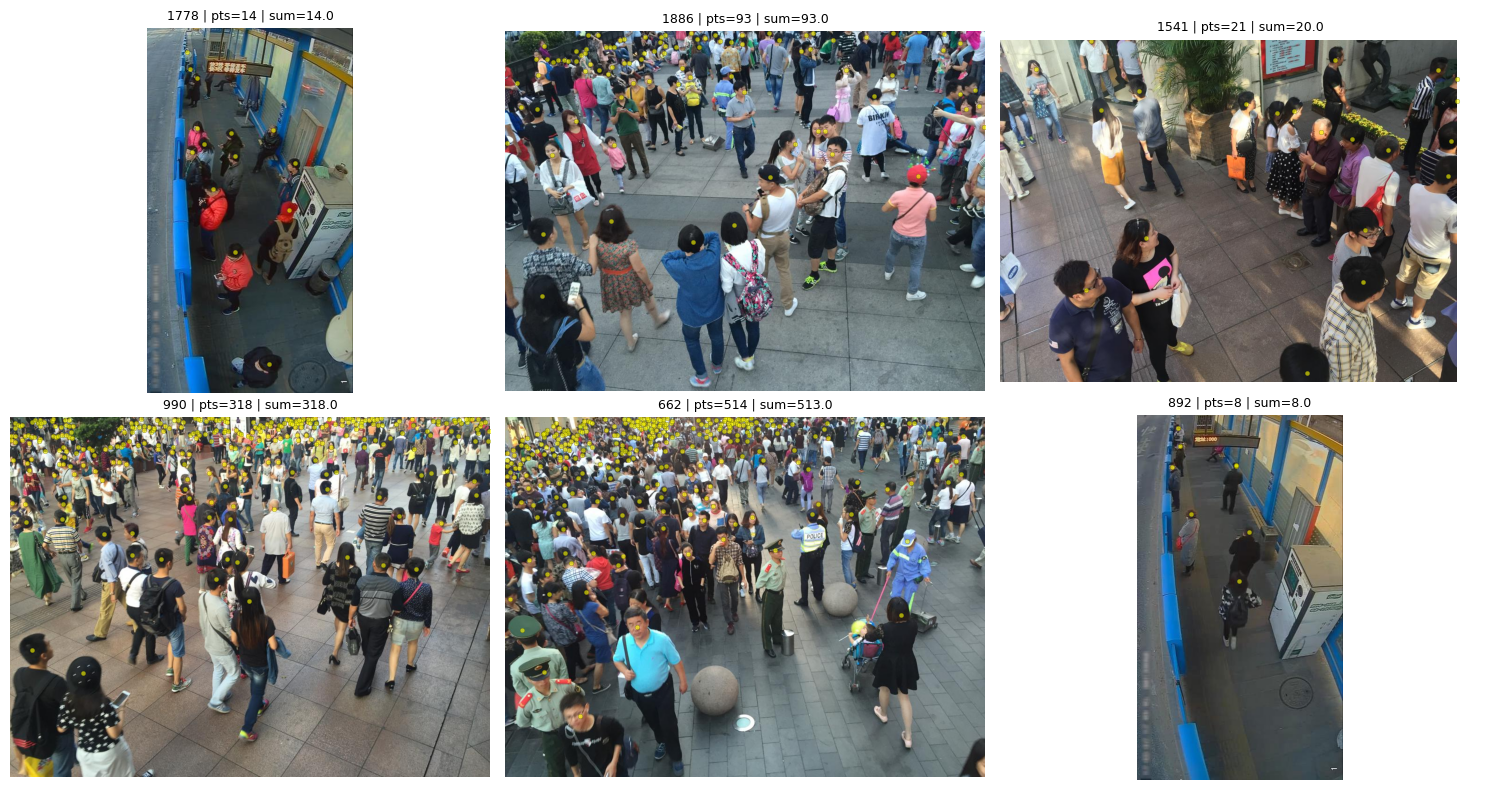

In [ ]:
# Visualisasi 2: Grid Multi Sampel

def visualize_grid(sample_ids, df_meta=None, maps_dir='/kaggle/working/preprocessed_maps/', cols=3, point_color='yellow'):
    if df_meta is None or 'id' not in df_meta.columns:
        print("DataFrame metadata tidak valid.")
        return
    valid_ids = [sid for sid in sample_ids if (df_meta['id'] == sid).any()]
    if not valid_ids:
        print("Tidak ada ID yang valid.")
        return
    rows = int(np.ceil(len(valid_ids) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.flatten():
        ax.axis('off')
    for idx, sid in enumerate(valid_ids):
        row_meta = df_meta[df_meta['id']==sid].iloc[0]
        img_path = row_meta['image_path']
        map_path = os.path.join(maps_dir, f"{sid}.npy")
        if not (os.path.exists(img_path) and os.path.exists(map_path)):
            continue
        img = Image.open(img_path).convert('RGB')
        density = np.load(map_path)
        points = row_meta.get('points', [])
        norm_pts = []
        if isinstance(points, (list, tuple)):
            for p in points:
                if isinstance(p,(list,tuple)) and len(p)==2:
                    try: norm_pts.append((float(p[0]), float(p[1])))
                    except: pass
                elif isinstance(p, dict):
                    for kx,ky in [("x","y"),("X","Y")]:
                        if kx in p and ky in p:
                            try: norm_pts.append((float(p[kx]), float(p[ky]))); break
                            except: pass
        ax = axes.flatten()[idx]
        ax.imshow(img)
        for (x,y) in norm_pts[:300]:  # limit overlay jika sangat padat
            ax.scatter(x, y, s=12, c=point_color, alpha=0.6, edgecolors='black', linewidths=0.2)
        ax.set_title(f"{sid} | pts={len(norm_pts)} | sum={density.sum():.1f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_grid(df_train_enriched['id'].sample(6, random_state=SEED), df_train_enriched)

## Ringkasan EDA (Singkat)


*   **Distribusi:** Count sangat skewed (banyak sparse, sedikit very-dense).  
*   **Bucket dominan:** 0–10 & 10–50 → risiko bias ke low density.  
*   **Label:** Mismatch & duplikasi minim, format koordinat heterogen berhasil dinormalisasi.  
*   **Spasial:** Jarak KNN rata-rata turun saat count naik → mendukung sigma adaptif.  
*   **Statistik:** Shapiro → non-normal; Spearman log(count) vs mean distance negatif → justifikasi adaptive kernel.  
*   **Density map:** Sum ≈ jumlah titik (konservasi terjaga).   
*   **Implikasi modeling:** Perlu weighting untuk high / very-dense & mungkin oversampling.   

**Kesimpulan:** Desain CSRNet + adaptive density & weighted loss selaras dengan karakter data; fokus perbaikan di segmen very-dense.

## Langkah 4 — Dataset & DataLoader

### 4.1. Tujuan
Menggabungkan citra + density map menjadi sample terstandardisasi untuk training.

### 4.2. Output per Sample
```
(image_tensor, density_map_downsampled, image_id)
```

### 4.3. Downsampling
- Output CSRNet berada pada resolusi 1/8 dari input (akibat pooling & dilated conv)
- Density map GT disesuaikan (interpolate) lalu di-*rescale* agar total count tetap terjaga

### 4.4. Validasi Kualitas
| Pemeriksaan | Tujuan |
|-------------|--------|
| Sum sebelum vs sesudah downsample | Konservasi count |
| Shape tensor | Kompatibilitas forward pass |
| File .npy ada | Hindari error runtime |

> Dataset dirancang ringan dan hanya memuat file saat diakses (lazy loading).

In [ ]:
# ===================================================================
# Langkah 4: Definisi Kelas PyTorch Dataset (Versi Optimal)
# ===================================================================
class CrowdCountingDataset(Dataset):
    def __init__(self, df, image_transform=None, is_train=True):
        self.df = df
        self.image_transform = image_transform
        self.is_train = is_train
        self.map_path = '/kaggle/working/preprocessed_maps/'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        map_file_path = os.path.join(self.map_path, f"{row['id']}.npy")
        density_map_np = np.load(map_file_path)

        img_tensor = self.image_transform(img) if self.image_transform else transforms.ToTensor()(img)
        map_tensor = transforms.ToTensor()(density_map_np)

        ground_truth_count = map_tensor.sum()
        _, h, w = img_tensor.shape
        target_h, target_w = h // 8, w // 8

        map_tensor_downsampled = F.interpolate(
            map_tensor.unsqueeze(0),
            size=(target_h, target_w),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

        current_sum = map_tensor_downsampled.sum()
        if current_sum > 1e-6:
            map_tensor_downsampled *= (ground_truth_count / current_sum)

        return img_tensor, map_tensor_downsampled, row['id']

In [ ]:
def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    d_rate = 2 if dilation else 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Langkah 5 — Arsitektur Model (CSRNet)

### 5.1. Desain
- Frontend: VGG16 (layer conv awal pretrained) → ekstraksi fitur tekstur & tepi.
- Backend: Dilated convolutions → meningkatkan receptive field tanpa kehilangan resolusi relatif.
- Output layer: 1-channel regresi density.

### 5.2. Keunggulan CSRNet
| Aspek | Manfaat |
|-------|---------|
| Pretrained VGG16 | Transfer representasi stabil |
| Dilated stack | Tangkap konteks global crowd |
| Tanpa decoder kompleks | Lebih ringan untuk inferensi |

### 5.3. Inisialisasi
- Jika tidak pakai pretrained, semua conv dinormalisasi (`std=0.01`).
- ReLU inplace untuk efisiensi memori.

> Output raw (tanpa activation akhir) karena target berupa nilai kontinu density.

In [ ]:
# ===================================================================
# Langkah 5: Definisi Arsitektur Model (CSRNet)
# ===================================================================

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if load_weights else None)
        self.frontend = nn.Sequential(*list(vgg16.features.children())[:23])
        self.backend = make_layers([512, 512, 512, 256, 128, 64], in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
# 1. LOSS FUNCTION - Kembali ke Combined Loss yang Terbukti Berhasil
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.5, mae_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
        self.mse_loss = nn.MSELoss(reduction='none')  # Changed to 'none'
        self.mae_loss = nn.L1Loss(reduction='none')   # Changed to 'none'

    def forward(self, pred, target):
        # Calculate base losses
        mse = self.mse_loss(pred, target)
        mae = self.mae_loss(pred, target)

        # Calculate density-based weights
        target_counts = target.sum(dim=(1,2,3))  # Total count per sample
        weights = torch.ones_like(target_counts)

        # Apply higher weights for high-density cases
        high_density_mask = target_counts > 100  # Threshold for "high density"
        weights[high_density_mask] *= 2.0  # 2x weight for high density cases

        very_high_density_mask = target_counts > 200
        weights[very_high_density_mask] *= 3.0  # 3x weight for very high density

        # Reshape weights for broadcasting
        weights = weights.view(-1, 1, 1, 1)

        # Apply weights and sum
        weighted_mse = (mse * weights).sum()
        weighted_mae = (mae * weights).sum()

        return self.mse_weight * weighted_mse + self.mae_weight * weighted_mae

## Langkah 6 — Training & Validasi

### 6.1. Komponen
| Komponen | Detail |
|----------|--------|
| Split | 80% train / 20% valid (stratifikasi tidak diterapkan sederhana) |
| Loss | CombinedLoss (MSE + MAE dengan weighting density) |
| Optimizer | Adam (lr=1e-5, weight_decay=5e-5) |
| Scheduler | ReduceLROnPlateau (factor 0.7, patience 5) |
| Gradient Control | clip_grad_norm_=1.0 |
| Checkpoint | Simpan model dengan MAE terbaik |

In [ ]:
# ===================================================================
# Langkah 6: Loop Pelatihan dan Validasi Model
# ===================================================================
# 1. Persiapan Data
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=SEED)

train_dataset = CrowdCountingDataset(train_df, image_transform=image_transforms)
val_dataset = CrowdCountingDataset(val_df, image_transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"Jumlah data training: {len(train_dataset)}")
print(f"Jumlah data validasi: {len(val_dataset)}")

Jumlah data training: 1520
Jumlah data validasi: 380


### 6.2. Alur Epoch
1. Forward → Hitung loss → Backprop → Update bobot
2. Validasi: hitung pred count via `sum(density)`
3. Logging: train_loss, val_loss, val_MAE, stability status

### 6.3. Stability Heuristic
- STD MAE window 5 epoch < 3 → STABLE
- STD besar → VOLATILE (perlu investigasi: LR, overfit, data noise)


### 6.4. Target
- Tracking internal menuju MAE < 15

> Sistem early warning & celebratory log membantu pengambilan keputusan eksperimen selanjutnya.

In [ ]:
# 2. Setup Pelatihan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")
model = CSRNet().to(device)

criterion = CombinedLoss().to(device)

# KONFIGURASI YANG TERBUKTI BERHASIL (dari training MAE 17.35)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-5,           # Conservative LR yang terbukti stabil
    weight_decay=5e-5  # Light regularization
)

# ReduceLROnPlateau - Adaptive dan responsive
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,     # Gentle reduction
    patience=5,     # Patient dengan data noisy
    verbose=True,
    min_lr=1e-6
)

Menggunakan device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# 3. Loop Pelatihan dan Validasi
epochs = 100
best_mae = float('inf')
output_dir = "/kaggle/working/models"
os.makedirs(output_dir, exist_ok=True)
best_model_path = "" # Untuk menyimpan path model terbaik

### 6.5. Penjelasan Tambahan Loop
Bagian berikut mengeksekusi loop training & validasi multi-epoch, lengkap dengan:
- Progress bar per fase
- Clip gradient (stabilkan update pada high density batch)
- Adaptive LR scheduler (turun saat plateau)
- Penyimpanan model terbaik otomatis

> Bila variasi MAE besar → bisa eksplor smoothing batch size, augmentasi, atau tuning sigma adaptif.

In [ ]:
# Tracking untuk early warning
recent_maes = []

for epoch in range(epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, density_maps, _ in train_pbar:
        images, density_maps = images.to(device), density_maps.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, density_maps)
        loss.backward()

        # Conservative gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()
        train_pbar.set_postfix(loss=loss.item() / images.size(0))

    train_loss = running_loss / len(train_dataset)

    # VALIDATION
    model.eval()
    epoch_mae = 0.0
    val_loss = 0.0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

    with torch.no_grad():
        for images, density_maps, _ in val_pbar:
            images, density_maps = images.to(device), density_maps.to(device)
            gt_counts = density_maps.sum(dim=(1, 2, 3))
            outputs = model(images)
            pred_counts = outputs.sum(dim=(1, 2, 3))

            epoch_mae += torch.abs(pred_counts - gt_counts).sum().item()
            val_loss += criterion(outputs, density_maps).item()

    val_mae = epoch_mae / len(val_dataset)
    val_loss = val_loss / len(val_dataset)

    # Track recent MAE untuk stability monitoring
    recent_maes.append(val_mae)
    if len(recent_maes) > 5:
        recent_maes.pop(0)

    # Stability check
    if len(recent_maes) >= 5:
        mae_std = np.std(recent_maes)
        stability_status = "STABLE" if mae_std < 3.0 else "VOLATILE"
    else:
        stability_status = "WARMING_UP"

    print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.2f} | Status: {stability_status}")

    # Scheduler update
    scheduler.step(val_mae)

    # Save best model
    if val_mae < best_mae:
        best_mae = val_mae
        best_model_path = os.path.join(output_dir, f"stable_model_mae_{best_mae:.2f}.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"New best MAE: {best_mae:.2f}")

    # Early warning system
    if len(recent_maes) >= 5 and np.std(recent_maes) > 10:
        print("WARNING: High volatility detected!")

    # Early celebration
    if best_mae < 15.0:
        print(f"TARGET ACHIEVED! Best MAE: {best_mae:.2f}")

print(f"\nTraining Complete!")
print(f"Best MAE: {best_mae:.2f}")
print(f"Target achieved: {'YES' if best_mae < 15.0 else 'NO'}")

Epoch 1/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 1/100 -> Train Loss: 425.7128 | Val Loss: 308.0513 | Val MAE: 30.81 | Status: WARMING_UP
New best MAE: 30.81


Epoch 2/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 2/100 -> Train Loss: 366.3403 | Val Loss: 311.3098 | Val MAE: 66.51 | Status: WARMING_UP


Epoch 3/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 3/100 -> Train Loss: 347.2729 | Val Loss: 280.4432 | Val MAE: 26.59 | Status: WARMING_UP
New best MAE: 26.59


Epoch 4/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 4/100 -> Train Loss: 339.5656 | Val Loss: 269.1322 | Val MAE: 30.70 | Status: WARMING_UP


Epoch 5/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 5/100 -> Train Loss: 325.8854 | Val Loss: 265.0942 | Val MAE: 33.95 | Status: VOLATILE


Epoch 6/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 6/100 -> Train Loss: 321.5133 | Val Loss: 263.3761 | Val MAE: 28.23 | Status: VOLATILE


Epoch 7/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 7/100 -> Train Loss: 316.2464 | Val Loss: 261.6672 | Val MAE: 24.99 | Status: VOLATILE
New best MAE: 24.99


Epoch 8/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 8/100 -> Train Loss: 311.5485 | Val Loss: 263.9837 | Val MAE: 36.05 | Status: VOLATILE


Epoch 9/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 9/100 -> Train Loss: 307.8298 | Val Loss: 279.3935 | Val MAE: 22.66 | Status: VOLATILE
New best MAE: 22.66


Epoch 10/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 10/100 -> Train Loss: 303.1995 | Val Loss: 264.0768 | Val MAE: 45.47 | Status: VOLATILE


Epoch 11/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 11/100 -> Train Loss: 299.6846 | Val Loss: 258.7523 | Val MAE: 35.36 | Status: VOLATILE


Epoch 12/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 12/100 -> Train Loss: 297.0038 | Val Loss: 259.8324 | Val MAE: 36.46 | Status: VOLATILE


Epoch 13/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 13/100 -> Train Loss: 297.6217 | Val Loss: 255.4892 | Val MAE: 26.14 | Status: VOLATILE


Epoch 14/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 14/100 -> Train Loss: 288.0623 | Val Loss: 251.8170 | Val MAE: 19.54 | Status: VOLATILE
New best MAE: 19.54


Epoch 15/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 15/100 -> Train Loss: 286.7799 | Val Loss: 254.7156 | Val MAE: 37.84 | Status: VOLATILE


Epoch 16/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 16/100 -> Train Loss: 282.9579 | Val Loss: 250.6440 | Val MAE: 29.58 | Status: VOLATILE


Epoch 17/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 17/100 -> Train Loss: 277.8399 | Val Loss: 246.9859 | Val MAE: 24.90 | Status: VOLATILE


Epoch 18/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 18/100 -> Train Loss: 273.6399 | Val Loss: 264.5208 | Val MAE: 22.44 | Status: VOLATILE


Epoch 19/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 19/100 -> Train Loss: 274.4578 | Val Loss: 254.1539 | Val MAE: 34.42 | Status: VOLATILE


Epoch 20/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 20/100 -> Train Loss: 267.8987 | Val Loss: 261.8017 | Val MAE: 38.88 | Status: VOLATILE


Epoch 21/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 21/100 -> Train Loss: 256.5230 | Val Loss: 252.1430 | Val MAE: 25.66 | Status: VOLATILE


Epoch 22/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 22/100 -> Train Loss: 250.9468 | Val Loss: 269.3475 | Val MAE: 19.81 | Status: VOLATILE


Epoch 23/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 23/100 -> Train Loss: 248.3049 | Val Loss: 259.2674 | Val MAE: 21.27 | Status: VOLATILE


Epoch 24/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 24/100 -> Train Loss: 242.9125 | Val Loss: 263.6091 | Val MAE: 18.83 | Status: VOLATILE
New best MAE: 18.83


Epoch 25/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 25/100 -> Train Loss: 237.8539 | Val Loss: 254.2994 | Val MAE: 23.25 | Status: STABLE


Epoch 26/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 26/100 -> Train Loss: 231.2459 | Val Loss: 251.0155 | Val MAE: 21.57 | Status: STABLE


Epoch 27/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 27/100 -> Train Loss: 228.7252 | Val Loss: 261.5330 | Val MAE: 20.19 | Status: STABLE


Epoch 28/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 28/100 -> Train Loss: 220.3275 | Val Loss: 261.8759 | Val MAE: 25.45 | Status: STABLE


Epoch 29/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 29/100 -> Train Loss: 215.9899 | Val Loss: 275.2396 | Val MAE: 19.59 | Status: STABLE


Epoch 30/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 30/100 -> Train Loss: 213.1907 | Val Loss: 256.8628 | Val MAE: 19.59 | Status: STABLE


Epoch 31/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 31/100 -> Train Loss: 203.5469 | Val Loss: 265.2549 | Val MAE: 28.54 | Status: VOLATILE


Epoch 32/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 32/100 -> Train Loss: 198.5246 | Val Loss: 262.4902 | Val MAE: 20.34 | Status: VOLATILE


Epoch 33/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 33/100 -> Train Loss: 194.9247 | Val Loss: 258.4162 | Val MAE: 22.28 | Status: VOLATILE


Epoch 34/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 34/100 -> Train Loss: 190.4977 | Val Loss: 260.2787 | Val MAE: 18.85 | Status: VOLATILE


Epoch 35/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 35/100 -> Train Loss: 190.2584 | Val Loss: 271.8408 | Val MAE: 19.85 | Status: VOLATILE


Epoch 36/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 36/100 -> Train Loss: 185.3139 | Val Loss: 264.3264 | Val MAE: 21.91 | Status: STABLE


Epoch 37/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 37/100 -> Train Loss: 179.1627 | Val Loss: 263.5667 | Val MAE: 24.95 | Status: STABLE


Epoch 38/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 38/100 -> Train Loss: 176.3568 | Val Loss: 271.0382 | Val MAE: 21.59 | Status: STABLE


Epoch 39/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 39/100 -> Train Loss: 173.5673 | Val Loss: 274.1766 | Val MAE: 14.71 | Status: VOLATILE
New best MAE: 14.71
TARGET ACHIEVED! Best MAE: 14.71


Epoch 40/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 40/100 -> Train Loss: 171.2580 | Val Loss: 269.0470 | Val MAE: 26.92 | Status: VOLATILE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 41/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 41/100 -> Train Loss: 169.0655 | Val Loss: 272.0094 | Val MAE: 20.97 | Status: VOLATILE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 42/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 42/100 -> Train Loss: 166.8979 | Val Loss: 270.2975 | Val MAE: 20.78 | Status: VOLATILE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 43/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 43/100 -> Train Loss: 164.5668 | Val Loss: 271.1900 | Val MAE: 21.28 | Status: VOLATILE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 44/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 44/100 -> Train Loss: 162.3954 | Val Loss: 272.1766 | Val MAE: 22.71 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 45/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 45/100 -> Train Loss: 161.1635 | Val Loss: 265.7290 | Val MAE: 23.96 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 46/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 46/100 -> Train Loss: 157.3364 | Val Loss: 272.2009 | Val MAE: 22.98 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 47/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 47/100 -> Train Loss: 154.5473 | Val Loss: 276.2039 | Val MAE: 22.00 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 48/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 48/100 -> Train Loss: 152.8604 | Val Loss: 272.8224 | Val MAE: 22.57 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 49/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 49/100 -> Train Loss: 151.8608 | Val Loss: 274.8079 | Val MAE: 22.68 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 50/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 50/100 -> Train Loss: 150.0263 | Val Loss: 279.8835 | Val MAE: 19.61 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 51/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 51/100 -> Train Loss: 148.9472 | Val Loss: 284.5727 | Val MAE: 18.29 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 52/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 52/100 -> Train Loss: 146.4390 | Val Loss: 276.1855 | Val MAE: 20.19 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 53/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 53/100 -> Train Loss: 145.0481 | Val Loss: 275.5254 | Val MAE: 20.71 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 54/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 54/100 -> Train Loss: 143.2777 | Val Loss: 273.8388 | Val MAE: 19.46 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 55/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 55/100 -> Train Loss: 142.3379 | Val Loss: 275.7922 | Val MAE: 20.69 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 56/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 56/100 -> Train Loss: 141.5887 | Val Loss: 275.3241 | Val MAE: 22.44 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 57/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 57/100 -> Train Loss: 140.2754 | Val Loss: 278.5400 | Val MAE: 18.16 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 58/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 58/100 -> Train Loss: 138.2746 | Val Loss: 278.5003 | Val MAE: 20.05 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 59/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 59/100 -> Train Loss: 137.3620 | Val Loss: 278.4208 | Val MAE: 23.37 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 60/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 60/100 -> Train Loss: 136.4887 | Val Loss: 279.4789 | Val MAE: 20.44 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 61/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 61/100 -> Train Loss: 135.8316 | Val Loss: 278.3700 | Val MAE: 20.44 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 62/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 62/100 -> Train Loss: 134.9259 | Val Loss: 277.8062 | Val MAE: 20.02 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 63/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 63/100 -> Train Loss: 134.3726 | Val Loss: 278.5914 | Val MAE: 21.69 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 64/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 64/100 -> Train Loss: 133.2464 | Val Loss: 279.1669 | Val MAE: 21.78 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 65/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 65/100 -> Train Loss: 132.8152 | Val Loss: 280.9493 | Val MAE: 18.11 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 66/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 66/100 -> Train Loss: 131.8058 | Val Loss: 279.5671 | Val MAE: 19.32 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 67/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 67/100 -> Train Loss: 131.1634 | Val Loss: 279.2566 | Val MAE: 22.74 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 68/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 68/100 -> Train Loss: 130.7884 | Val Loss: 278.8530 | Val MAE: 22.53 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 69/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 69/100 -> Train Loss: 130.4158 | Val Loss: 279.3497 | Val MAE: 21.68 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 70/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 70/100 -> Train Loss: 129.5214 | Val Loss: 280.1145 | Val MAE: 20.04 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 71/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 71/100 -> Train Loss: 129.3272 | Val Loss: 281.1500 | Val MAE: 19.59 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 72/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 72/100 -> Train Loss: 128.4960 | Val Loss: 285.2648 | Val MAE: 18.39 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 73/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 73/100 -> Train Loss: 128.3936 | Val Loss: 284.5744 | Val MAE: 20.45 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 74/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 74/100 -> Train Loss: 127.9587 | Val Loss: 281.6850 | Val MAE: 19.39 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 75/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 75/100 -> Train Loss: 127.1997 | Val Loss: 280.5588 | Val MAE: 21.55 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 76/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 76/100 -> Train Loss: 126.5191 | Val Loss: 283.1213 | Val MAE: 19.80 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 77/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 77/100 -> Train Loss: 125.8076 | Val Loss: 281.6590 | Val MAE: 20.41 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 78/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 78/100 -> Train Loss: 125.4010 | Val Loss: 282.4893 | Val MAE: 20.81 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 79/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 79/100 -> Train Loss: 124.9117 | Val Loss: 282.6858 | Val MAE: 18.01 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 80/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 80/100 -> Train Loss: 124.8076 | Val Loss: 282.9028 | Val MAE: 20.02 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 81/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 81/100 -> Train Loss: 123.8084 | Val Loss: 281.4903 | Val MAE: 20.97 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 82/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 82/100 -> Train Loss: 123.5518 | Val Loss: 282.7720 | Val MAE: 20.89 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 83/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 83/100 -> Train Loss: 122.9774 | Val Loss: 282.0889 | Val MAE: 20.89 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 84/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 84/100 -> Train Loss: 122.5714 | Val Loss: 285.5851 | Val MAE: 19.74 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 85/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 85/100 -> Train Loss: 121.8546 | Val Loss: 282.7536 | Val MAE: 21.31 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 86/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 86/100 -> Train Loss: 121.6261 | Val Loss: 282.5366 | Val MAE: 20.67 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 87/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 87/100 -> Train Loss: 121.2838 | Val Loss: 282.7860 | Val MAE: 20.04 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 88/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 88/100 -> Train Loss: 120.6049 | Val Loss: 281.6780 | Val MAE: 20.94 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 89/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 89/100 -> Train Loss: 120.3597 | Val Loss: 283.3292 | Val MAE: 19.53 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 90/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 90/100 -> Train Loss: 119.6859 | Val Loss: 284.8076 | Val MAE: 19.32 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 91/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 91/100 -> Train Loss: 119.3011 | Val Loss: 284.0019 | Val MAE: 20.45 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 92/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 92/100 -> Train Loss: 118.8219 | Val Loss: 287.2596 | Val MAE: 19.54 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 93/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 93/100 -> Train Loss: 118.5976 | Val Loss: 285.4271 | Val MAE: 19.54 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 94/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 94/100 -> Train Loss: 118.0120 | Val Loss: 285.1036 | Val MAE: 21.20 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 95/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 95/100 -> Train Loss: 118.0094 | Val Loss: 286.3942 | Val MAE: 20.03 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 96/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 96/100 -> Train Loss: 117.7737 | Val Loss: 285.6984 | Val MAE: 20.19 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 97/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 97/100 -> Train Loss: 117.5941 | Val Loss: 284.2174 | Val MAE: 20.71 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 98/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 98/100 -> Train Loss: 116.9667 | Val Loss: 286.2096 | Val MAE: 20.68 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 99/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 99/100 -> Train Loss: 116.6995 | Val Loss: 285.8974 | Val MAE: 19.59 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71


Epoch 100/100 [Training]:   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch 100/100 -> Train Loss: 116.1483 | Val Loss: 286.9810 | Val MAE: 18.93 | Status: STABLE
TARGET ACHIEVED! Best MAE: 14.71

Training Complete!
Best MAE: 14.71
Target achieved: YES


## Langkah 7 — Evaluasi Visual

Evaluasi kuantitatif (MAE) dilengkapi evaluasi kualitatif:
- Bandingkan pola distribusi density (GT vs Pred)
- Validasi apakah model tidak over-smooth atau terlalu noisy
- Observasi failure case (undercount high density / overcount low density)

### Panel Tampilan per Sampel
| Panel | Isi |
|-------|-----|
| 1 | Gambar asli (denormalized) |
| 2 | GT Density + GT Count |
| 3 | Pred Density + Pred Count |

> Insight kualitatif sering membantu merancang perbaikan (augmentasi, weighting, perbaikan kernel).


Menampilkan contoh prediksi pada data validasi...


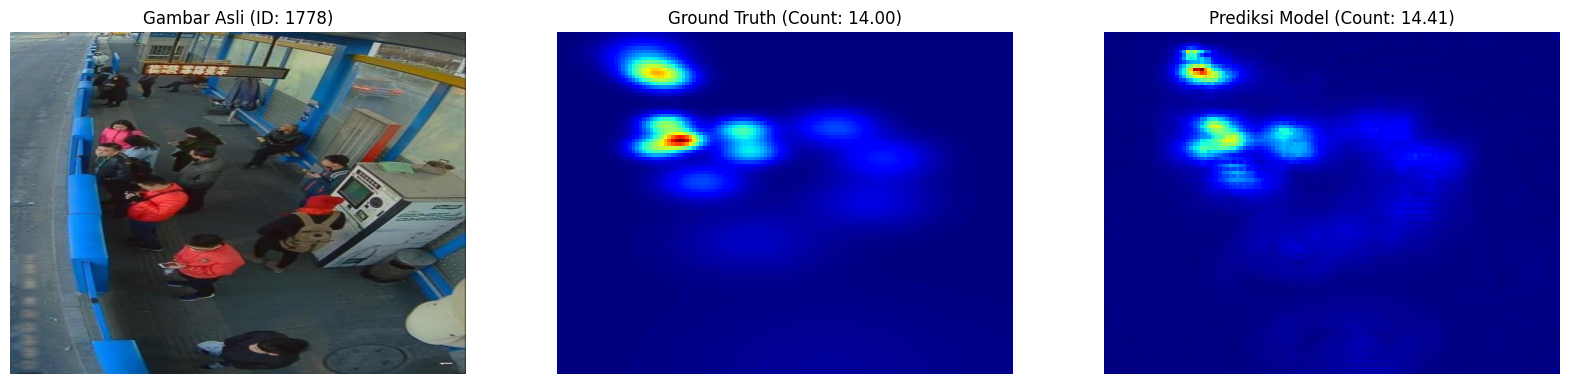

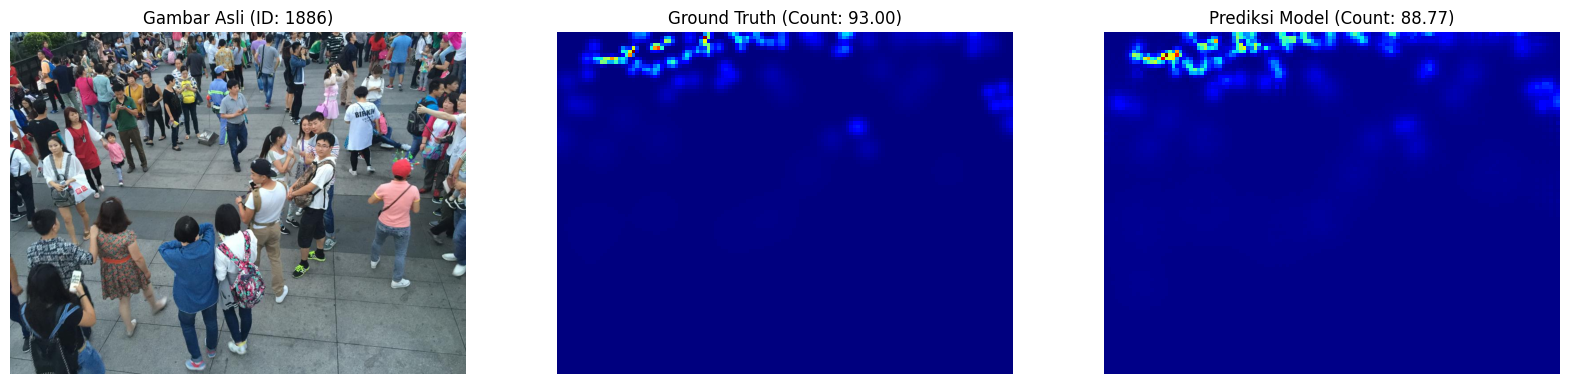

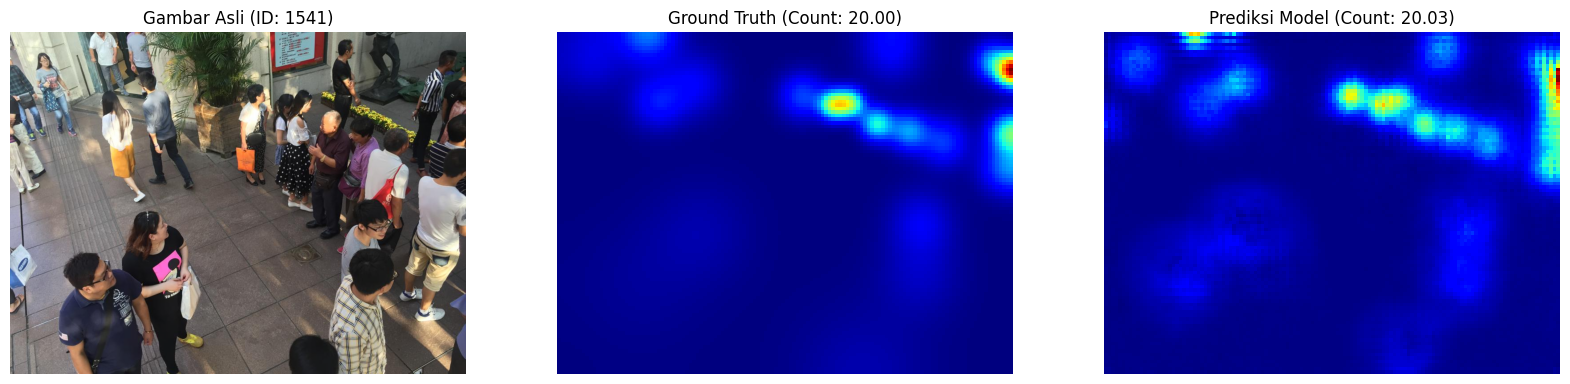

In [ ]:
# ===================================================================
# Langkah 7: Evaluasi Model Secara Visual
# ===================================================================

def visualize_predictions(model, dataloader, num_samples=3, best_model_path=""):
    """Memvisualisasikan beberapa prediksi dari dataloader."""
    if not os.path.exists(best_model_path):
        print(f"Error: File model tidak ditemukan di {best_model_path}")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval()

    with torch.no_grad():
        images, density_maps, image_ids = next(iter(dataloader))
        images = images.to(device)
        pred_maps = model(images).cpu()

        for i in range(min(num_samples, images.size(0))):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            gt_map, pred_map = density_maps[i].squeeze().numpy(), pred_maps[i].squeeze().numpy()
            gt_count, pred_count = gt_map.sum(), pred_map.sum()

            fig, axes = plt.subplots(1, 3, figsize=(20, 10))
            axes[0].imshow(img)
            axes[0].set_title(f"Gambar Asli (ID: {image_ids[i]})")
            axes[1].imshow(gt_map, cmap='jet')
            axes[1].set_title(f"Ground Truth (Count: {gt_count:.2f})")
            axes[2].imshow(pred_map, cmap='jet')
            axes[2].set_title(f"Prediksi Model (Count: {pred_count:.2f})")
            for ax in axes: ax.axis('off')
            plt.show()

print("\nMenampilkan contoh prediksi pada data validasi...")
visualize_predictions(model, val_loader, num_samples=3, best_model_path=best_model_path)

## Langkah 8 — Inferensi & Submission
Membangun pipeline inferensi pada test set dan menghasilkan file `submission.csv` sesuai format kompetisi.

### 8.1. Tahap Utama
1. Susun metadata test
2. Bangun `TestDataset` (tanpa label)
3. Forward pass model pada batch test
4. Hitung prediksi count (sum density)
5. Bulatkan & clamp ke ≥ 0
6. Simpan ke CSV

> File final diverifikasi secara struktural sebelum diunggah ke Kaggle.

In [ ]:
# ===================================================================
# Langkah 8: Membuat File Submission
# ===================================================================

# 1. Persiapan Data Tes
test_ids = sorted([os.path.splitext(f)[0] for f in os.listdir(TEST_IMG_PATH) if f.endswith('.jpg')])
test_metadata = [{'id': img_id, 'image_path': os.path.join(TEST_IMG_PATH, f"{img_id}.jpg")} for img_id in test_ids]
df_test = pd.DataFrame(test_metadata)

### 8.2. Dataset Test
Dataset test hanya memerlukan transform gambar + ID. Tidak ada density map. Output dataset: `(image_tensor, image_id)`.

In [ ]:
# 2. Buat Dataset dan DataLoader untuk Tes
class TestDataset(Dataset):
    def __init__(self, df, image_transform=None):
        self.df = df
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')
        img_id = row['id']
        if self.image_transform:
            img = self.image_transform(img)
        return img, img_id

test_dataset = TestDataset(df_test, image_transform=image_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

### 8.3. Prediksi Batch
- Model memproduksi density map
- Count = sum piksel density
- Dipost-proses: dibulatkan → integer ≥ 0
- Disimpan bertahap ke list `predictions`

In [ ]:
# 3. Loop Prediksi
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()
predictions = []
test_pbar = tqdm(test_loader, desc="Membuat prediksi pada data tes")

with torch.no_grad():
    for images, image_ids in test_pbar:
        images = images.to(device)
        outputs = model(images)
        pred_counts = outputs.sum(dim=(1, 2, 3)).cpu().numpy()

        for img_id, count in zip(image_ids, pred_counts):
            predicted_count = max(0, int(round(count)))
            predictions.append({'image_id': f"{img_id}.jpg", 'predicted_count': predicted_count})

Membuat prediksi pada data tes:   0%|          | 0/63 [00:00<?, ?it/s]

### 8.4. Pembuatan CSV
Pastikan:
- Kolom tersusun: `image_id,predicted_count`
- Tidak ada duplikasi baris
- Semua file test tercakup

> Disarankan membuka 5 baris awal dan akhir untuk sanity check sebelum submit.

In [ ]:
# 4. Buat File CSV
df_submission = pd.DataFrame(predictions)
df_submission.to_csv('submission 10.csv', index=False)

print("\n✅ File submission_tta.csv berhasil dibuat!")
print("Contoh 5 baris pertama:")
print(df_submission.head())


✅ File submission_tta.csv berhasil dibuat!
Contoh 5 baris pertama:
  image_id  predicted_count
0    1.jpg               19
1   10.jpg               66
2  100.jpg              194
3  101.jpg                7
4  102.jpg              668


### 8.5. Analisis Tambahan per Rentang Density
Membagi sampel validasi ke beberapa bucket density:
- 0–10 (sparse)
- 10–50 (low-mid)
- 50–200 (dense)
- >200 (very dense)

Tujuan: mengetahui segmen mana yang paling lemah untuk strategi perbaikan (mis. weighting lanjutan / augmentasi targeted).

In [ ]:
# Jalankan ini untuk dapat info yang saya butuh
def analyze_current_performance(model, val_loader):
    model.eval()
    density_ranges = [(0,10), (10,50), (50,200), (200,float('inf'))]
    range_errors = {range_: [] for range_ in density_ranges}

    with torch.no_grad():
        for images, density_maps, _ in val_loader:
            gt_counts = density_maps.sum(dim=(1,2,3))
            pred_counts = model(images.to(device)).sum(dim=(1,2,3))

            for gt, pred in zip(gt_counts, pred_counts):
                error = abs(gt - pred).item()
                for range_ in density_ranges:
                    if range_[0] <= gt < range_[1]:
                        range_errors[range_].append(error)

    for range_, errors in range_errors.items():
        if errors:
            print(f"Range {range_}: MAE = {np.mean(errors):.2f}, Count = {len(errors)}")

# Jalankan analisis
print("Analyzing performance by density ranges...")
analyze_current_performance(model, val_loader)

Analyzing performance by density ranges...
Range (0, 10): MAE = 1.05, Count = 97
Range (10, 50): MAE = 2.38, Count = 131
Range (50, 200): MAE = 9.79, Count = 79
Range (200, inf): MAE = 60.33, Count = 73
